### Unsupervised DL algo (Autoencoders)  
---

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
LATENT_DIM = 512
TEST_SIZE = 0.2  # 20% for testing

# 1. Load and preprocess images with labels
def load_dataset(base_path):
    images = []
    labels = []
    
    # Define subfolder paths
    cats_path = os.path.join(base_path, 'Cat')
    dogs_path = os.path.join(base_path, 'Dog')
    
    # Load cat images (label = 0)
    for filename in os.listdir(cats_path):
        if filename.endswith(('.jpg', '.png')):
            img_path = os.path.join(cats_path, filename)
            try:
                img = resize_with_padding(img_path)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(0)  # Cats
            except Exception as e:
                print(f"Error processing {filename} in cats: {e}")
                continue
    
    # Load dog images (label = 1)
    for filename in os.listdir(dogs_path):
        if filename.endswith(('.jpg', '.png')):
            img_path = os.path.join(dogs_path, filename)
            try:
                img = resize_with_padding(img_path)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(1)  # Dogs
            except Exception as e:
                print(f"Error processing {filename} in dogs: {e}")
                continue
    
    images = np.stack(images)
    labels = np.array(labels, dtype=np.int32)
    # images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
    
    return images, labels

In [3]:
def resize_with_padding(image, target_size = 224):
    # Open the image and convert to RGB
    img = Image.open(image).convert('RGB')
    
    # Get original dimensions
    orig_width, orig_height = img.size
    ratio = min(target_size / orig_width, target_size / orig_height)
    
    # Resize while preserving aspect ratio
    new_width = int(orig_width * ratio)
    new_height = int(orig_height * ratio)
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create a new blank image with the target size and black padding
    padded_img = Image.new('RGB', (target_size, target_size), (0, 0, 0))  # Black padding
    
    # Calculate padding offsets to center the image
    pad_left = (target_size - new_width) // 2
    pad_top = (target_size - new_height) // 2
    
    # Paste the resized image onto the padded canvas
    padded_img.paste(img, (pad_left, pad_top))
    
    # Convert to tensor and normalize to [0, 1]
    # to_tensor = transforms.ToTensor()
    # img_tensor = to_tensor(padded_img)
    img_tensor = padded_img
    
    return img_tensor

In [4]:
# 2. Split into train and test sets
dataset_path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'


all_images, all_labels = load_dataset(dataset_path)
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=TEST_SIZE, stratify=all_labels, random_state=42
)

del all_images
del all_labels

print(f"Training set: {train_images.shape[0]} images")
print(f"Test set: {test_images.shape[0]} images")

Error processing 666.jpg in cats: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Error processing 11702.jpg in dogs: cannot identify image file '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg'
Training set: 19998 images
Test set: 5000 images


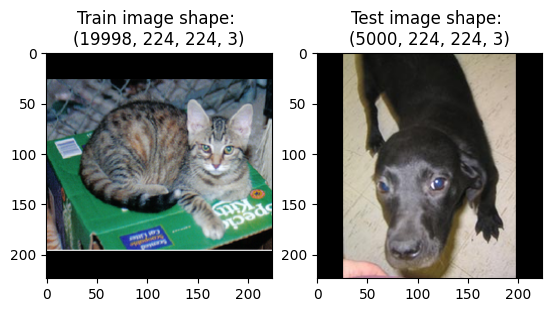

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(train_images[11]);
plt.title(f"Train image shape: \n{train_images.shape}")

plt.subplot(1, 2, 2)
plt.imshow(test_images[11]);
plt.title(f"Test image shape: \n{test_images.shape}")

plt.show()

---  
### Train

In [6]:
import keras

IMG_HEIGHT = 224
IMG_WIDTH = 224
LATENT_DIM = 512  # Size of the latent space

In [27]:
# 2. Build the Autoencoder
def build_autoencoder(img_shape, LATENT_DIM):
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(layers.Input(img_shape))
    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 112x112
    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 56x56
    encoder.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 28x28
    encoder.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))  # 14x14
    encoder.add(layers.Flatten())  # 14 * 14 * 256 = 50,176
    encoder.add(layers.Dense(LATENT_DIM))  # 256
    


    
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(layers.Input(shape=(LATENT_DIM,)))
    decoder.add(layers.Dense(14 * 14 * 256))  # Reverse the flatten
    decoder.add(layers.Reshape((14, 14, 256)))  # 14x14
    decoder.add(layers.Conv2DTranspose(256, (3 , 3), activation='elu', strides=2, padding='same'))
    # decoder.add(layers.UpSampling2D((2, 2)))  # 28x28
    decoder.add(layers.Conv2DTranspose(128, (3, 3), activation='elu', strides=2, padding='same'))
    # decoder.add(layers.UpSampling2D((2, 2)))  # 56x56
    decoder.add(layers.Conv2DTranspose(64, (3, 3), activation='elu', strides=2, padding='same'))
    # decoder.add(layers.UpSampling2D((2, 2)))  # 112x112
    decoder.add(layers.Conv2DTranspose(32, (3, 3), activation='elu', strides=2, padding='same'))
    # decoder.add(layers.UpSampling2D((2, 2)))  # 224x224
    decoder.add(layers.Conv2DTranspose(3, (3, 3), activation=None, padding='same'))
    
    

    return encoder, decoder

In [15]:
IMG_SHAPE = train_images.shape[1:]
IMG_SHAPE

(224, 224, 3)

In [28]:
# Create and compile the model
encoder, decoder = build_autoencoder(IMG_SHAPE, LATENT_DIM)
encoder.summary()
decoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │      25,690,624 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,079,040 (99.48 MB)

 Trainable params: 26,079,040 (99.48 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 50176)               │      25,740,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 28, 28, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ (None, 56, 56, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ (None, 112, 112, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_34                  │ (None, 224, 224, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_35                  │ (None, 224, 224, 3)         │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,718,531 (101.92 MB)

 Trainable params: 26,718,531 (101.92 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# # Autoencoder
img_shape = train_images.shape[1:]
autoencoder_input = layers.Input(img_shape)
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = models.Model(inputs = autoencoder_input, outputs = decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

In [30]:
# 3. Train the Autoencoder

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, fill_mode='nearest')
# datagen.fit(train_images)

# noise_factor = 0.1
# noisy_images = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
# noisy_images = np.clip(noisy_images, 0., 1.)
# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
# autoencoder.fit(x=noisy_images, y=train_images, epochs=50, batch_size=16, validation_split=0.2)

history = autoencoder.fit(x=train_images, y=train_images,  # Input and target are the same
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_split=0.2,
                verbose=1)

# lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
# autoencoder.fit(x=images, y=images, epochs=100, batch_size=32, validation_split=0.2, callbacks=[lr_schedule])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 116s 101ms/step - loss: 4040.9795 - val_loss: 1198.6561
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - loss: 1140.0375 - val_loss: 975.9017
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - loss: 946.7618 - val_loss: 832.4426
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - loss: 812.6733 - val_loss: 817.9382
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - loss: 754.7646 - val_loss: 692.7215
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - loss: 673.1581 - val_loss: 623.6087
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/step - loss: 623.5595 - val_loss: 631.9658
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/step - loss: 591.5512 - val_loss: 563.5363
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/step - loss: 544.9100 - val_loss: 549.4435
Epoch 10/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/step - loss: 519.2581 - val_loss: 505.8217
Epoch 11/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 93ms/st

In [39]:
# 4. Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

---  
### View similar images

In [31]:
# 4. Extract latent features
imagess = train_images
encoded_images  = encoder.predict(imagess)

625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step


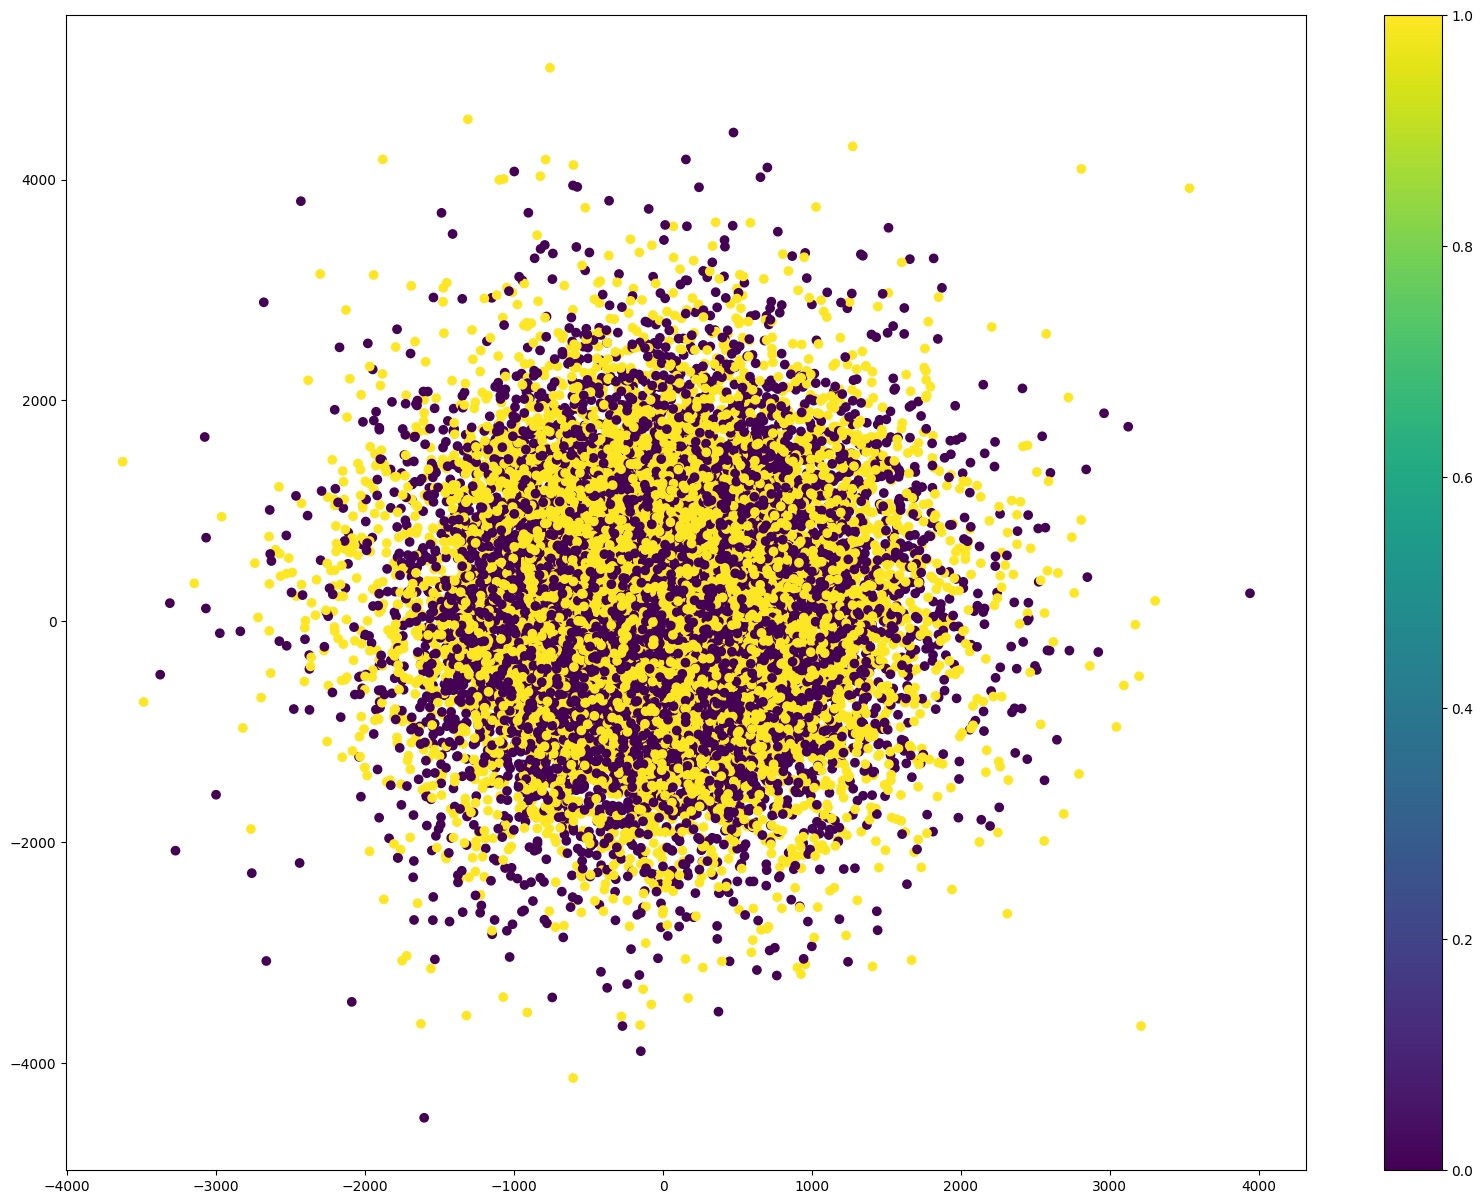

In [32]:
#Clustering using Kmeans:
#Assuming we have 6 classes:e.g. lion, tiger, cheetah, leopard, wolf, fox

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
kmeans.fit(encoded_images)
plt.figure(figsize=(20, 15))
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.show()

In [ ]:
###Fitting our encoded images on Nearest Neighbors algorithms to retrieve similar images

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(encoded_images)

In [ ]:
#Function for retrieving distances and indexes of similar images

def get_similar(image, n_neighbors):
    encoded_image = encoder.predict(image[None])
    #Getting distances and indexes of nearest neighbors
    (distances,),(idx,) = nei_clf.kneighbors(encoded_image,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
#Function for showing similar images:
def show_similar(image,n_neighbors):
    
    distances,neighbors = get_similar(image,n_neighbors)
    n_neighbor = n_neighbors-1 # for For loop
    dim = round(n_neighbors/2)
    #Plot for original image
    plt.figure(figsize=[30,30])
    plt.subplot(dim,dim,1)
    plt.imshow(image)
    plt.title("Original image")
    #Plot for neighbors
    for i in range(n_neighbor):
        plt.subplot(dim,dim,i+2)
        plt.imshow(neighbors[i+1])
        plt.title("Dist=%.3f"%distances[i+1])
    plt.show()
     


In [ ]:
show_similar(imagess[40],15)

---  


In [33]:
# Get latent features for test data
test_latent_features = encoder.predict(test_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [34]:
# Cluster the test data

# import warnings
# warnings.filterwarnings('ignore')
# kmeans = KMeans(n_clusters=2, n_init=20, random_state=42)
# test_cluster_labels = kmeans.fit_predict(test_latent_features)


from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, random_state=42)
test_cluster_labels = gmm.fit_predict(test_latent_features)

In [35]:
# Map clusters to labels (manual step after inspection)
# Example: if cluster 0 is mostly cats (true_labels = 0), keep as is; otherwise, swap
mapped_labels = test_cluster_labels  # Adjust based on inspection (e.g., 1 - test_cluster_labels to swap)


In [36]:
# Calculate accuracy
accuracy = np.mean(mapped_labels == test_labels)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 52.48%


In [37]:

# Visualize some examples
def plot_examples(images, true_labels, pred_labels, num_examples=120):
    plt.figure(figsize=(120, 120))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {true_labels[i]}\nPred: {pred_labels[i]}')
        plt.axis('off')
    plt.show()


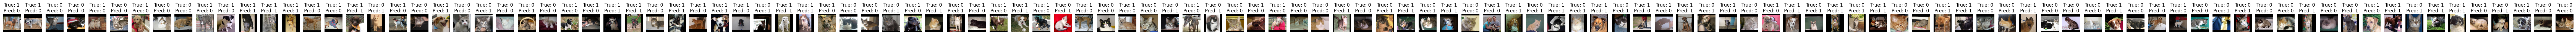

In [38]:
# Show first 5 examples
plot_examples(test_images, test_labels, mapped_labels)